In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive = h5py.File("data/archive_18sco.hdf5", 'r')

In [2]:
wl_min = 5160
wl_max = 5180

class Spectrum(object): 
    def __init__(self, wl, fl): 
        wl_range = ((wl < wl_max) & (wl > wl_min))
        self.wavelength = wl[wl_range]
        self.flux = fl[wl_range]

(0, 2)

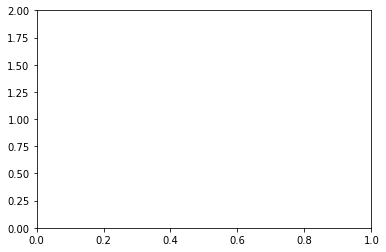

In [3]:
spectra = []
keys = list(archive)
for isot in keys: 
    sp = Spectrum(*archive[isot][:])
    spectra.append(sp)
    
#     if sp.flux.max() < 1.2:
#         plt.plot(sp.wavelength, sp.flux)

#tio = 5598.410

tio = control = 5208.5 #5603.8 #5594.6 #5602.9 #5593.75 #5594.5

# plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 2])

In [4]:
# # Expensive, only run once:
dx = []
for i in range(1, len(spectra)):
    cross_corr = np.correlate(spectra[0].flux - np.median(spectra[0].flux), 
                              spectra[i].flux - np.median(spectra[i].flux), mode='same')
    
    dx.append(cross_corr.shape[0]//2 - cross_corr.argmax())

np.save('data/dx_18Sco.npy', dx)

# dx = np.load('data/dx_18Sco.npy')

In [5]:
from astropy.time import Time
dates = Time(keys, format='isot')

In [6]:
# for i, j in zip(dates.iso, all_fs): 
#     print(i, j)

In [7]:
from json import load
f_S = load(open('../f_S.json'))

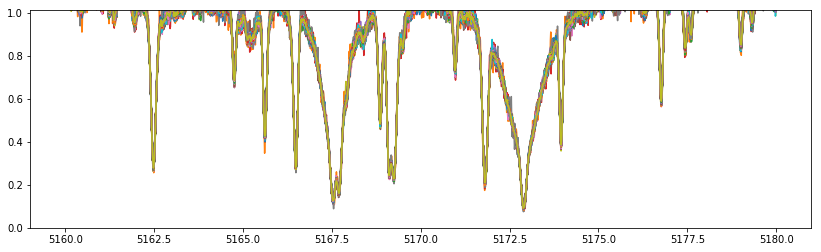

In [10]:
coadded = spectra[0].flux

spectral_grid = spectra[0].flux #np.zeros((len(spectra)-1, len(spectra[0].wavelength)))
all_fs = []

delta_wavelength = np.median(np.abs(np.diff(spectra[0].wavelength)))

spectra_indices = []

plt.figure(figsize=(14, 4))
for i in range(1, len(spectra)): 
    # Quality filter
#     if True:
    if spectra[i].flux.max() < 1.2:
        spectra_indices.append(i)
        date_key = str(dates[i-1].datetime.date())    
#         all_fs.append(f_S[date_key])
        wavelength_shift = dx[i-1] * delta_wavelength
    
        rolled_spectrum = np.interp(spectra[0].wavelength, spectra[i].wavelength - wavelength_shift, spectra[i].flux, left=1, right=1)
        rolled_spectrum /= np.median(rolled_spectrum)

        plt.plot(spectra[i].wavelength, rolled_spectrum)
        coadded += rolled_spectrum
        
        spectral_grid = np.vstack([spectral_grid, rolled_spectrum])

coadded /= np.median(coadded)
        
# plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 1.01])
spectra_indices = np.array(spectra_indices)

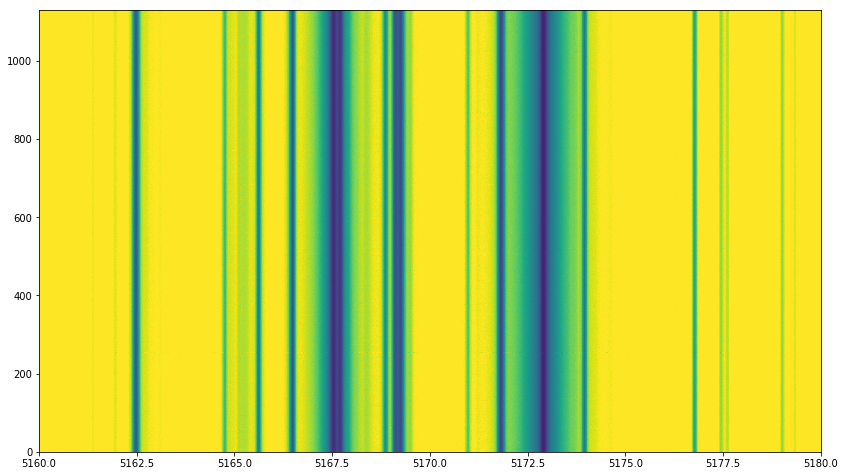

In [11]:
plt.figure(figsize=(14, 14))
extent = [spectra[0].wavelength.min(), spectra[0].wavelength.max(), 
          0, len(spectra_indices)]
plt.imshow(spectral_grid, origin='lower', extent=extent, vmin=0, vmax=1)
plt.gca().set_aspect(0.01)

In [40]:
sum_spectrum = np.median(spectral_grid, axis=0)

In [41]:
residuals = np.zeros_like(spectral_grid)

for i in range(spectral_grid.shape[0]): 
    X = np.vstack([spectra[i].flux, spectra[0].wavelength, np.ones(len(spectra[0].wavelength))]).T
    c = np.linalg.lstsq(X, sum_spectrum)[0]
    residuals[i, :] = X @ c - sum_spectrum
    
# Normalize residuals
residuals = residuals / residuals.ptp()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


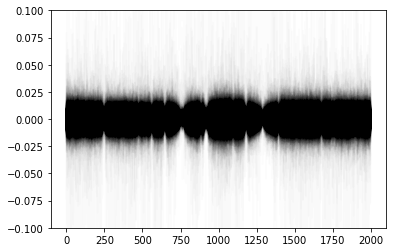

In [42]:
for residual in residuals: 
    residual -= np.median(residual)
    plt.plot(residual, alpha=0.01, color='k')
plt.ylim([-0.1, 0.1])
plt.show()

In [43]:
np.save('data/residuals_18Sco.npy', residuals)

In [31]:
from keras.models import load_model

model = load_model('data/model.hdf5')

In [32]:
from scipy.interpolate import interp1d

In [44]:
resample_residuals = interp1d(np.arange(residuals.shape[1]), residuals)(np.linspace(0, residuals.shape[1] - 1, residuals.shape[1] + 1))

predict_y = model.predict(resample_residuals[:, :, np.newaxis])

(array([1122.,    0.,    0.,    0.,    0.,    3.,    0.,    0.,    0.,
           5.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

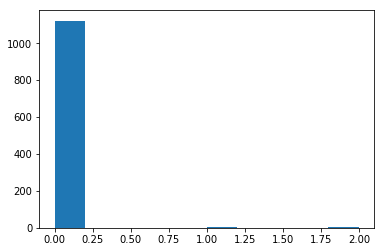

In [45]:
plt.hist(predict_y.argmax(axis=1))

In [35]:
resample_residuals.sum(axis=0).shape

(2000,)

In [46]:
predict_y_sum = model.predict(np.median(resample_residuals, axis=0)[np.newaxis, :, np.newaxis])

In [47]:
predict_y_sum

array([[0.9615303 , 0.01203717, 0.02643243]], dtype=float32)